In [140]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

%matplotlib inline

## Loading the data
We can now load the dataset into pandas using the read_csv() function. This converts the CSV file into a Pandas dataframe.

In [141]:
#Read in the csv file and convert to a Pandas dataframe
df_Football_Players = pd.read_csv("..\..\data\clean_data.csv")

In [142]:
df_Football_Players.shape

(9592, 23)

## Model




### Feature engineering: 

- Feature scaling
- Aggregation
- One hot coding

-------------------

In [143]:
df_Football_Players = df_Football_Players.drop(['name','player'],axis=1)

In [144]:
categorical_features = df_Football_Players.select_dtypes(include=object).columns
numeric_features = df_Football_Players.select_dtypes(include=np.number).columns
categorical_features

Index(['team', 'position'], dtype='object')

In [145]:
# one hot coding for categorical_features
df_Football_Players = pd.get_dummies(df_Football_Players,columns=categorical_features)


In [146]:
df_Football_Players.head()

,Unnamed: 0,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,1,196.0,30.0,15,0.000000,0.000000,0.069018,0.0,0.0,1.242331,...,False,False,False,True,False,False,False,False,False,False
1,8,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False
2,10,169.0,23.0,89,0.012619,0.063096,0.227145,0.0,0.0,0.000000,...,False,True,False,False,False,False,False,False,False,False
3,11,180.0,22.0,34,0.000000,0.033507,0.335071,0.0,0.0,0.000000,...,False,True,False,False,False,False,False,False,False,False
4,20,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,0.0,0.000000,...,False,False,False,False,False,False,True,False,False,False


In [147]:
df_Football_Players.shape

(9592, 409)

In [148]:
# Calculate the 35th and 75th percentiles of the current_value
p35 = df_Football_Players['current_value'].quantile(0.35)
p75 = df_Football_Players['current_value'].quantile(0.75)

# Function to categorize current_value
def categorize_value(value):
    if value < p35:
        return 'low value'
    elif value < p75:
        return 'Good value'
    else:
        return 'High value'

# Apply the function to create a new column
df_Football_Players['current_value_category'] = df_Football_Players['current_value'].apply(categorize_value)

df_Football_Players.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df_Football_Players['current_value_category'].value_counts())

current_value_category
Good value    4029
low value     3158
High value    2405
Name: count, dtype: int64


In [149]:
p35, p75

(400000.0, 2200000.0)

In [150]:
df_Football_Players['current_value_category']

0       Good value
1       Good value
2       High value
3       High value
4       Good value
           ...    
9587     low value
9588     low value
9589     low value
9590     low value
9591     low value
Name: current_value_category, Length: 9592, dtype: object

In [151]:
encoder = LabelEncoder()
df_Football_Players['current_value_category_encoded'] = encoder.fit_transform(df_Football_Players['current_value_category'])  

In [152]:
df_Football_Players['current_value_category_encoded'].value_counts()

current_value_category_encoded
0    4029
2    3158
1    2405
Name: count, dtype: int64

#### 3. Feature selection


In [153]:
correlation = df_Football_Players.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
Unnamed: 0                        0.210937
position_Goalkeeper               0.143520
position_midfield                 0.105393
goals conceded                    0.093105
                                    ...   
age                              -0.128170
days_injured                     -0.144245
games_injured                    -0.153077
minutes played                   -0.233125
appearance                       -0.253403
Name: current_value_category_encoded, Length: 409, dtype: float64


In [154]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > threshold]['current_value_category_encoded'].index
selected_features

Index(['Unnamed: 0', 'age', 'appearance', 'goals', 'minutes played',
       'days_injured', 'games_injured', 'award', 'position_encoded',
       'position_Goalkeeper', 'position_midfield',
       'current_value_category_encoded'],
      dtype='object')

In [155]:
df_Football_Players = df_Football_Players[selected_features]
df_Football_Players.head()

,Unnamed: 0,age,appearance,goals,minutes played,days_injured,games_injured,award,position_encoded,position_Goalkeeper,position_midfield,current_value_category_encoded
0,1,30.0,15,0.000000,1304,510,58,1,1,True,False,0
1,8,21.0,34,0.000000,2758,47,13,0,2,False,False,0
2,10,23.0,89,0.012619,7132,182,15,3,2,False,False,1
3,11,22.0,34,0.000000,2686,175,28,1,2,False,False,1
4,20,20.0,39,0.129125,2788,0,0,1,3,False,False,0


In [156]:
df_Football_Players.shape

(9592, 12)

### Prepare train and test data


In [157]:
# Prepare data
X = df_Football_Players.drop(['current_value_category_encoded'], axis=1)
y = df_Football_Players['current_value_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=99)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [158]:
X.shape

(9592, 11)

In [159]:
y.shape

(9592,)

### Build the model

In [160]:
svm_classifier = SVC() 


In [161]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[1, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=svm_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

### Train the Model

In [162]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [167]:
grid_search.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [168]:
model = grid_search.best_estimator_

### Test the Model


In [169]:
# Predict and evaluate the model
y_pred_test = model.predict(X_test_scaled)

### Evaluating the Model

In [170]:
# our benchmark model
base_model = round(df_Football_Players['current_value_category_encoded'].value_counts()[1]/df_Football_Players.shape[0]*100, 2)
base_model

25.07

#### Accuracy

In [171]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy_Train = accuracy_score(y_train, y_pred_train)
print(f"Train score: {accuracy_Train}")

Train score: 0.8326599765411182


In [172]:
# Test score
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test
print(f"Test score: {accuracy_test}")

Test score: 0.662324127149557


##### Confusion matrix


In [173]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[601,  76, 140],
       [198, 262,  24],
       [199,  11, 408]], dtype=int64)

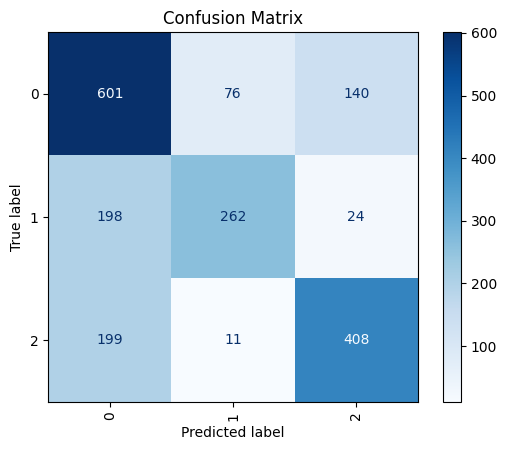

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

#### Precision

In [175]:
# Train score
precision_train = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision in train: {precision_train:.2f}")

# Test score
precision_test = precision_score(y_test, y_pred_test, average='macro')
print(f"Precision in test: {precision_test:.2f}")

Precision in train: 0.85
Precision in test: 0.69


#### Recall

In [176]:
# Train score
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall in train: {recall_train:.2f}")

# Test score
recall_test = recall_score(y_test, y_pred_test, average='macro')
print(f"Recall in test: {recall_test:.2f}")

Recall in train: 0.82
Recall in test: 0.65


#### F1-Score


In [177]:
# Train score
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"f1-score in train: {f1_train:.2f}")

# Test score
f1_test = precision_score(y_test, y_pred_test, average='macro')
print(f"f1-score in test: {f1_test:.2f}")

f1-score in train: 0.83
f1-score in test: 0.69


### Classification report

In [178]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train))

print('Test report: ')
print(classification_report(y_test, y_pred_test))

Train report: 
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      3212
           1       0.91      0.77      0.84      1921
           2       0.85      0.83      0.84      2540

    accuracy                           0.83      7673
   macro avg       0.85      0.82      0.83      7673
weighted avg       0.84      0.83      0.83      7673

Test report: 
              precision    recall  f1-score   support

           0       0.60      0.74      0.66       817
           1       0.75      0.54      0.63       484
           2       0.71      0.66      0.69       618

    accuracy                           0.66      1919
   macro avg       0.69      0.65      0.66      1919
weighted avg       0.68      0.66      0.66      1919

